<a href="https://colab.research.google.com/github/RodrigoOBC/TCC-CienciaDados/blob/Modelo_local/ModeloFinalEntrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fluxo Independente

Para realizar o download da base de dados é só entrar no seguinte link:

https://drive.google.com/drive/folders/1VQpWhlzK__2EUfd4CMeUWQ8-wAHaWGeT?usp=sharing


Inicialmente, importaremos as Bibliotecas necessárias para a criação do modelo.A principais bibliotecas serão"TensorFlow"para criação das estruturas da "RedeNeural"e"Pandas"para criação e manipulação dos"DataFremes"

## Importa Bibliotecas

In [1]:
import re
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score,f1_score 
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

##Declaração de constantes

Declaração de algumas constantes, como: caminho principal dos dados, tamanho das imagens, o "BatchSize" e o número de "Epocas" padrão no treinamento. Usamos por padrão "25 épocas" e formos aumentando conforme o necessário

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
EPOCHS = 25

## Criação dos DataFremes



In [3]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file_name in files:
            nome_file.append(file_name)
            file_path.append(p+'//'+file_name)
    return nome_file, file_path
    
def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        nome = ''.join([i for i in nome if not i.isdigit()])
        nome = nome.split('.')[0]
        if "TA" == nome:
            classe.append('TA')
        elif "DCI" == nome:
            classe.append('DCI')
        elif "F" == nome:
            classe.append('F')
        elif "PT" == nome:
            classe.append('PT')
        elif "DC" == nome:
            classe.append('DC')
        elif "LC" == nome:
            classe.append('LC')
        elif "MC" == nome:
            classe.append('MC')
        elif "PC" == nome:
            classe.append('PC')
        elif 'A' == nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        path = path.split('/')[8]
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df

In [4]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [5]:
df_treino.head()

,FikePath,Type,classes,Magnification,DataSet
0,/content/drive/MyDrive/TCC/Imagens/400x/400x_T...,M,DC,400x,Tr
1,/content/drive/MyDrive/TCC/Imagens/400x/400x_T...,M,DC,400x,Tr
2,/content/drive/MyDrive/TCC/Imagens/400x/400x_T...,M,DC,400x,Tr
3,/content/drive/MyDrive/TCC/Imagens/400x/400x_T...,M,DC,400x,Tr
4,/content/drive/MyDrive/TCC/Imagens/400x/400x_T...,M,DC,400x,Tr


In [6]:
df_teste.head()

,FikePath,Type,classes,Magnification,DataSet
786,/content/drive/MyDrive/TCC/Imagens/400x/400x_t...,M,DC,400x,Te
787,/content/drive/MyDrive/TCC/Imagens/400x/400x_t...,M,DC,400x,Te
788,/content/drive/MyDrive/TCC/Imagens/400x/400x_t...,M,DC,400x,Te
789,/content/drive/MyDrive/TCC/Imagens/400x/400x_t...,M,DC,400x,Te
790,/content/drive/MyDrive/TCC/Imagens/400x/400x_t...,M,DC,400x,Te


## Segmentação do Dataframe

Com o *"dataframe"* conseguiremos segmentar os dados de acordo com sua *"Magnification"*. 

Separando para 200x e para 400x

In [7]:
df_treino_400 = df_treino[df_treino['Magnification'] == '400x']
df_treino_400 = df_treino_400.drop(columns=['Magnification'])

df_teste_400 = df_teste[df_teste['Magnification'] == '400x']
df_teste_400 = df_teste_400.drop(columns=['Magnification'])



df_treino_200 = df_treino[df_treino['Magnification'] == '200x']
df_treino_200 = df_treino_200.drop(columns=['Magnification'])

df_teste_200 = df_teste[df_teste['Magnification'] == '200x']
df_teste_200 = df_teste_200.drop(columns=['Magnification'])

In [8]:
df_treino_400_classe = df_treino[df_treino['Magnification'] == '400x'][df_treino['Type'] == 'M']
df_treino_400_classe = df_treino_400_classe.drop(columns=['Magnification'])

df_teste_400_classe = df_teste[df_teste['Magnification'] == '400x'][df_teste['Type'] == 'M']
df_teste_400_classe = df_teste_400_classe.drop(columns=['Magnification'])



df_treino_200_classe = df_treino[df_treino['Magnification'] == '200x'][df_treino['Type'] == 'M']
df_treino_200_classe = df_treino_200_classe.drop(columns=['Magnification'])

df_teste_200_classe  = df_teste[df_teste['Magnification'] == '200x'][df_teste['Type'] == 'M']
df_teste_200_classe = df_teste_200_classe.drop(columns=['Magnification'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


# Criação dos datas Generatos

Todos os 3 ImageDataGenerator terão em comum as adiçoes de rotação em 10%, a de adição de zoom em 20%. No caso de validação será sempre 20% do dado de treinamento

### ImageDataGenerator para VGG19

In [9]:
train_generator_VGG19 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)
test_generator_VGG19= tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

### ImageDataGenerator para GoogleNet

In [10]:
train_generator_googleNet = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_generator_googleNet = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

### ImageDataGenerator para ResNet50


In [11]:
train_generator_ResNet = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_generator_ResNet  = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

# Execução dos Modelos


Nessa seção apresentarei o "passo a passo" da execução dos modelos. Começare-mos apresentando como foi realizado a criação do modelo *VGG19*, logo em seguidaserá apresentado a criação do modelo *InceptionV3* e por fim a utilização da arquitetura *RESNET50*.

## Modelo Tipo de Cancer


Na primeira sessão de treinamento como falado antes, prepararemos a nossa redeneural para identificar um câncer maligno. Seguiremos o seguinte passo-a-passo para esse treinamento.



In [ ]:
def build_model(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    base_RESNET = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
    x = base_RESNET.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_RESNET.input, outputs = preds)
  
  return model

### Modelo VGG19 Para grau de ampliação 400

In [ ]:
train_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_VGG19_MB = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
VGG19 = build_model("VGG19")
VGG19.load_weights('/content/drive/MyDrive/TCC/weights/VGG19/VGG_MB_com_pesos.h5')

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
opt = Adam(learning_rate=0.0001)
VGG19.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19.predict(test_images_VGG19_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df_400=df_teste_400.copy()
labels={}
for l,v in test_images_VGG19_MB.class_indices.items():
    labels.update({v:l})
pred_df_400['pred']=pred
pred_df_400['pred']=pred_df_400['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_400['Type'],pred_df_400['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.98      0.95      0.96       560
           M       0.93      0.97      0.95       418

    accuracy                           0.96       978
   macro avg       0.96      0.96      0.96       978
weighted avg       0.96      0.96      0.96       978



In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df_400['Type'],pred_df_400['pred'])}")

Accuracy Score: 0.9580777096114519


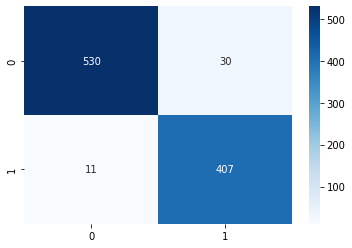

In [ ]:

sns.heatmap(confusion_matrix(pred_df_400['Type'],pred_df_400['pred']), annot=True, fmt='2d',  cmap="Blues");


### Modelo VGG19 Para grau de ampliação 200

In [ ]:
train_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_VGG19_MB = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [ ]:
VGG19 = build_model("VGG19")
VGG19.load_weights('/content/drive/MyDrive/TCC/weights/VGG19/VGG_MB_com_pesos.h5')
opt = Adam(learning_rate=0.0001)
VGG19.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19.predict(test_images_VGG19_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df_200=df_teste_200.copy()
labels={}
for l,v in test_images_VGG19_MB.class_indices.items():
    labels.update({v:l})
pred_df_200['pred']=pred
pred_df_200['pred']=pred_df_200['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_200['Type'],pred_df_200['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.87      0.93       367
           M       0.91      1.00      0.95       489

    accuracy                           0.94       856
   macro avg       0.95      0.93      0.94       856
weighted avg       0.95      0.94      0.94       856



In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df_200['Type'],pred_df_200['pred'])}")

Accuracy Score: 0.9427570093457944


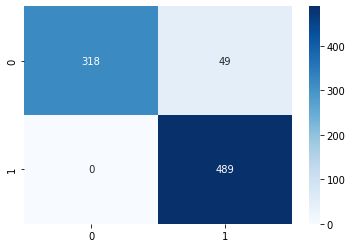

In [ ]:

sns.heatmap(confusion_matrix(pred_df_200['Type'],pred_df_200['pred']), annot=True, fmt='2d',  cmap="Blues");


### Modelo VGG19 Validação final

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 1834
quantidade de dados na base de Treino 1573


In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1834 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
VGG19_rede_Geral = build_model('VGG19')
checkpoint_path = r'/content/drive/MyDrive/TCC/weights/VGG19/VGG_MB_com_pesos.h5'
VGG19_rede_Geral.load_weights(checkpoint_path)
VGG19_rede_Geral.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19_rede_Geral.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.99      0.91      0.95       927
           M       0.92      0.99      0.95       907

    accuracy                           0.95      1834
   macro avg       0.95      0.95      0.95      1834
weighted avg       0.95      0.95      0.95      1834



In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")

Accuracy Score: 0.95092693565976


Accuracy Score: 0.95092693565976


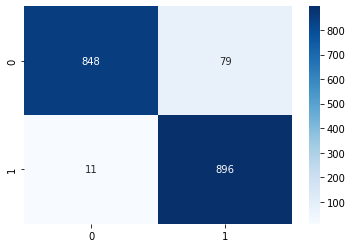

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Blues");

### Modelo GoogleNet Para grau de ampliação 400

In [ ]:
train_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_googlent_MB = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
Interception = build_model("GoogleNet")
Interception.load_weights(filepath=r'/content/drive/MyDrive/TCC/weights/Interception/Interception_MB_com_pesos.h5')
Interception.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                

In [ ]:
opt = Adam(learning_rate=0.0001)
Interception.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = Interception.predict(test_images_googlent_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400.copy()
labels={}
for l,v in test_images_googlent_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.96      0.98       560
           M       0.94      1.00      0.97       418

    accuracy                           0.97       978
   macro avg       0.97      0.98      0.97       978
weighted avg       0.98      0.97      0.97       978



Accuracy Score: 0.9744376278118609


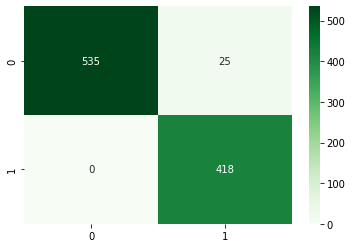

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',   cmap="Greens");

###  Modelo GoogleNet Para grau de ampliação 200

In [ ]:
train_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_googlent_MB = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [ ]:
pred = Interception.predict(test_images_googlent_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200.copy()
labels={}
for l,v in test_images_googlent_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.93      0.97       367
           M       0.95      1.00      0.98       489

    accuracy                           0.97       856
   macro avg       0.98      0.97      0.97       856
weighted avg       0.97      0.97      0.97       856



Accuracy Score: 0.9719626168224299


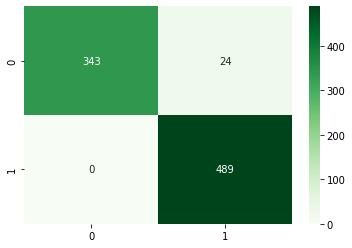

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',   cmap="Greens");

### Modelo GoogleNet validação geral

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
train_images = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1259 validated image filenames belonging to 2 classes.
Found 314 validated image filenames belonging to 2 classes.
Found 1834 validated image filenames belonging to 2 classes.


In [ ]:
pred = Interception.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.95      0.97       927
           M       0.95      1.00      0.97       907

    accuracy                           0.97      1834
   macro avg       0.97      0.97      0.97      1834
weighted avg       0.97      0.97      0.97      1834



Accuracy Score: 0.9732824427480916


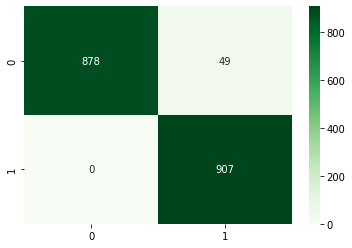

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Greens");

### Modelo ResNet50 Para grau de ampliação 400

In [ ]:
train_images_ResNet_MB = train_generator_ResNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_ResNet_MB = train_generator_ResNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_ResNet_MB = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
ResNet = build_model("Resnet")
ResNet.load_weights('/content/drive/MyDrive/TCC/weights/ResNet50/ResNet_MB_com_pesos.h5')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
opt = Adam(learning_rate=0.0001)
ResNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet.predict(test_images_ResNet_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400.copy()
labels={}
for l,v in test_images_ResNet_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.98      0.84      0.90       560
           M       0.82      0.98      0.89       418

    accuracy                           0.90       978
   macro avg       0.90      0.91      0.90       978
weighted avg       0.91      0.90      0.90       978



Accuracy Score: 0.8977505112474438


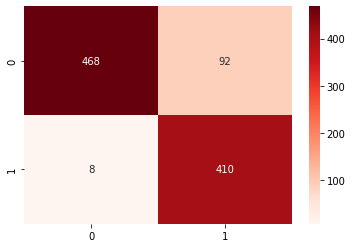

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Reds");

### Modelo ResNet50 Para grau de ampliação 200


In [ ]:


test_images_ResNet_MB = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 856 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
ResNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet.predict(test_images_ResNet_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200.copy()
labels={}
for l,v in test_images_ResNet_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.80      0.89       367
           M       0.87      1.00      0.93       489

    accuracy                           0.92       856
   macro avg       0.94      0.90      0.91       856
weighted avg       0.93      0.92      0.91       856



Accuracy Score: 0.9158878504672897


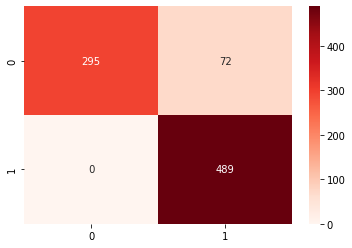

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Reds");

### Modelo ResNet50 validação geral

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
test_images_ResNet_MB = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1834 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
ResNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet.predict(test_images_ResNet_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_ResNet_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.99      0.82      0.90       927
           M       0.85      0.99      0.91       907

    accuracy                           0.91      1834
   macro avg       0.92      0.91      0.91      1834
weighted avg       0.92      0.91      0.91      1834



Accuracy Score: 0.906215921483097


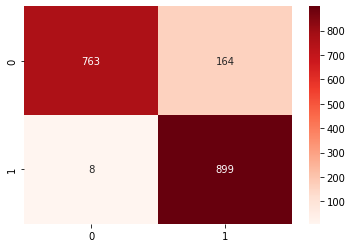

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d', cmap="Reds");

## Modelo Classe do Cancer


Apos o primeiro processo de treinamento. Será feita a segunda etapa onde classificaremos os canceres. Já tendo realizado a primeira etapade treinamento e validação realizaremos as novas etapas de treino.

In [ ]:
def build_model_classe(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    base_Interception = ResNet50(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  
  return model 

### Modelo VGG19 Para grau de ampliação 400

In [ ]:
test_images_VGG19_Classes_400 = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_400_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 418 validated image filenames belonging to 4 classes.


In [ ]:
VGG19_classes = build_model_classe("VGG19")
VGG19_classes.load_weights('/content/drive/MyDrive/TCC/weights/VGG19/VGG19_class.h5')
opt = Adam(learning_rate=0.0001)
VGG19_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
pred = VGG19_classes.predict(test_images_VGG19_Classes_400)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400_classe.copy()
labels={}
for l,v in test_images_VGG19_Classes_400.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.87      0.61      0.72       244
          LC       0.55      0.94      0.70        67
          MC       0.58      0.67      0.62        57
          PC       0.77      1.00      0.87        50

    accuracy                           0.72       418
   macro avg       0.69      0.81      0.73       418
weighted avg       0.77      0.72      0.72       418



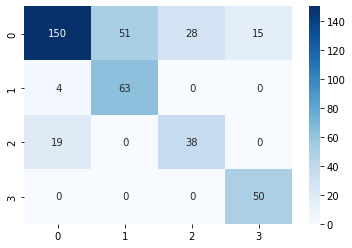

In [ ]:
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap="Blues");

### Modelo VGG19 Para grau de ampliação 200

In [ ]:
test_images_VGG19_Classes_200 = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_200_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 489 validated image filenames belonging to 4 classes.


In [ ]:
pred = VGG19_classes.predict(test_images_VGG19_Classes_200)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200_classe.copy()
labels={}
for l,v in test_images_VGG19_Classes_200.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       1.00      0.69      0.82       300
          LC       0.56      1.00      0.72        87
          MC       0.87      0.98      0.92        55
          PC       0.72      1.00      0.84        47

    accuracy                           0.81       489
   macro avg       0.79      0.92      0.82       489
weighted avg       0.88      0.81      0.81       489



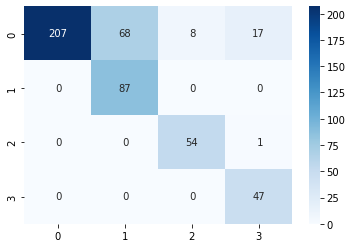

In [ ]:

sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap="Blues");

### Modelo VGG19 Validação geral

In [ ]:
VGG19_classes = build_model_classe("VGG19")
VGG19_classes.load_weights('/content/drive/MyDrive/TCC/weights/VGG19/VGG19_class.h5')
opt = Adam(learning_rate=0.0001)
VGG19_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Type'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_images_VGG19_Classes = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
test_images_VGG19 = test_images_VGG19_Classes.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 907 validated image filenames belonging to 4 classes.


In [ ]:
pred = VGG19_classes.predict(test_images_VGG19)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_VGG19.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Accuracy Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Accuracy Score:               precision    recall  f1-score   support

          DC       0.94      0.66      0.77       544
          LC       0.56      0.97      0.71       154
          MC       0.72      0.82      0.77       112
          PC       0.75      1.00      0.85        97

    accuracy                           0.77       907
   macro avg       0.74      0.86      0.78       907
weighted avg       0.83      0.77      0.77       907



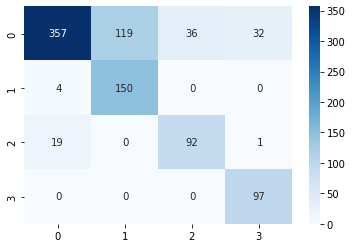

In [ ]:

sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap="Blues")

### Modelo GoogleNet Para grau de ampliação 400

In [ ]:
test_images_googleNet_Classes_400 = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_400_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 418 validated image filenames belonging to 4 classes.


In [ ]:
interception_classes = build_model_classe("GoogleNet")
interception_classes.load_weights('/content/drive/MyDrive/TCC/weights/Interception/Interception_class.h5')
opt = Adam(learning_rate=0.0001)
interception_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
pred = interception_classes.predict(test_images_googleNet_Classes_400)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400_classe.copy()
labels={}
for l,v in test_images_googleNet_Classes_400.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.98      0.82      0.89       244
          LC       0.91      0.61      0.73        67
          MC       0.84      0.98      0.90        57
          PC       0.50      1.00      0.66        50

    accuracy                           0.83       418
   macro avg       0.80      0.85      0.80       418
weighted avg       0.89      0.83      0.84       418



Accuracy Score: 0.8301435406698564


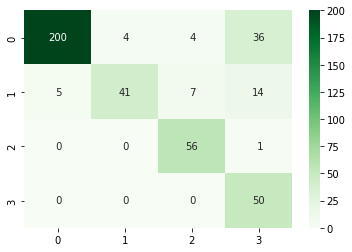

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Greens');

### Modelo GoogleNet Para grau de ampliação 200

In [ ]:
test_images_googleNet_Classes_200 = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_200_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
      shuffle=False
)

Found 489 validated image filenames belonging to 4 classes.


In [ ]:
pred = interception_classes.predict(test_images_googleNet_Classes_200)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200_classe.copy()
labels={}
for l,v in test_images_googleNet_Classes_200.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       1.00      0.90      0.95       300
          LC       0.99      0.98      0.98        87
          MC       0.90      1.00      0.95        55
          PC       0.66      1.00      0.80        47

    accuracy                           0.93       489
   macro avg       0.89      0.97      0.92       489
weighted avg       0.95      0.93      0.94       489



Accuracy Score: 0.934560327198364


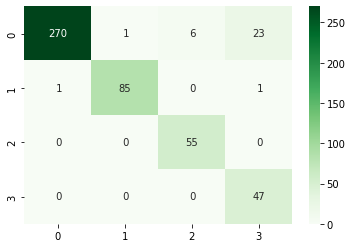

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Greens');

### Modelo GoogleNet Validação geral

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Type'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_images_googleNet = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 907 validated image filenames belonging to 4 classes.


In [ ]:
pred = interception_classes.predict(test_images_googleNet)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_googleNet.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.99      0.86      0.92       544
          LC       0.96      0.82      0.88       154
          MC       0.87      0.99      0.92       112
          PC       0.56      1.00      0.72        97

    accuracy                           0.89       907
   macro avg       0.85      0.92      0.86       907
weighted avg       0.92      0.89      0.89       907



Accuracy Score: 0.886438809261301


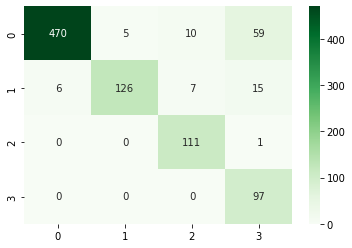

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Greens');

### Modelo ResNet Para grau de ampliação 400




In [ ]:
test_images_Resnet_Classes_400 = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_400_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 418 validated image filenames belonging to 4 classes.


In [ ]:
ResNet_classes = build_model_classe("Resnet")
ResNet_classes.load_weights('/content/drive/MyDrive/TCC/weights/ResNet50/ResNet_class.h5')
opt = Adam(learning_rate=0.0001)
ResNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
pred = ResNet_classes.predict(test_images_Resnet_Classes_400)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400_classe.copy()
labels={}
for l,v in test_images_Resnet_Classes_400.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.91      0.79      0.84       244
          LC       0.92      0.66      0.77        67
          MC       0.86      1.00      0.93        57
          PC       0.55      1.00      0.71        50

    accuracy                           0.82       418
   macro avg       0.81      0.86      0.81       418
weighted avg       0.86      0.82      0.83       418



Accuracy Score: 0.8229665071770335


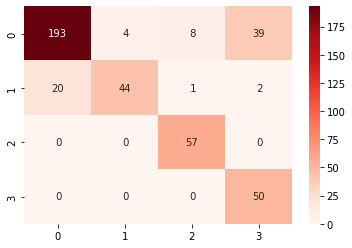

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Reds');

### Modelo ResNet Para grau de ampliação 200

In [ ]:
test_images_Resnet_Classes_200 = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_200_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 489 validated image filenames belonging to 4 classes.


In [ ]:
ResNet_classes = build_model_classe("Resnet")
ResNet_classes.load_weights('/content/drive/MyDrive/TCC/weights/ResNet50/ResNet_class.h5')
opt = Adam(learning_rate=0.0001)
ResNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet_classes.predict(test_images_Resnet_Classes_200)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200_classe.copy()
labels={}
for l,v in test_images_Resnet_Classes_200.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       1.00      0.81      0.89       300
          LC       0.88      0.99      0.93        87
          MC       0.95      1.00      0.97        55
          PC       0.52      1.00      0.69        47

    accuracy                           0.88       489
   macro avg       0.84      0.95      0.87       489
weighted avg       0.92      0.88      0.89       489



Accuracy Score: 0.8793456032719836


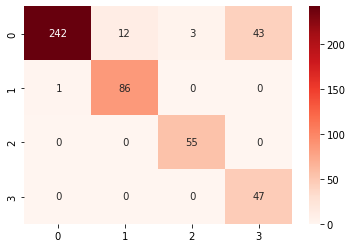

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Reds');

### Modelo ResNet Validação geral



In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Type'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_images_ResNet = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 907 validated image filenames belonging to 4 classes.


In [ ]:
ResNet_classes = build_model_classe("Resnet")
ResNet_classes.load_weights('/content/drive/MyDrive/TCC/weights/ResNet50/ResNet_class.h5')
opt = Adam(learning_rate=0.0001)
ResNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet_classes.predict(test_images_ResNet)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_ResNet.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.95      0.80      0.87       544
          LC       0.89      0.84      0.87       154
          MC       0.90      1.00      0.95       112
          PC       0.54      1.00      0.70        97

    accuracy                           0.85       907
   macro avg       0.82      0.91      0.85       907
weighted avg       0.89      0.85      0.86       907



Accuracy Score: 0.8533627342888643


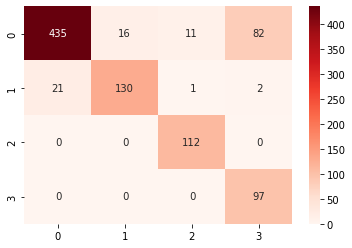

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Reds');

#Combinação dos modelos

Após as execuções dos modelos, e tendo visto separadamente cada avaliação percebemos que os melhores modelos até então são, o GoogleNet(InterceptionV3) para categoria e GoogleNet(InterceptionV3) para classe.

Agora realizaremos a combinação dos modelos, para definirmos a conjunção final do Projeto.


### Definição do dataframe e dos modelos

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_teste_categoria = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
def build_model(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    base_RESNET = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
    x = base_RESNET.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_RESNET.input, outputs = preds)
  
  return model

In [ ]:
def build_model_classe(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    base_Interception = ResNet50(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  
  return model 

### Configuração da VGG19 Categoria

In [ ]:
test_generator_VGG19_MB = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
test_images_VGG19_MB = test_generator_VGG19_MB.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1834 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
VGG19_rede_MB = build_model('VGG19')
checkpoint_path = r'/content/drive/MyDrive/TCC/weights/VGG19/VGG_MB_com_pesos.h5'
VGG19_rede_MB.load_weights(checkpoint_path)
VGG19_rede_MB.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

80150528/80134624 [==============================] - 0s 0us/step


## Combinação 1 

### Modelo VGG19 Categoria com Modelo GoogleNet Classes

### Execução modelo VGG19 Categoria

In [ ]:
pred_VGG19 = VGG19_rede_MB.predict(test_images_VGG19_MB)
pred_VGG19_gmax=np.argmax(pred_VGG19,axis=1)

In [ ]:
labels={}
pred_df_VGG19_MB=df_teste.copy()
for l,v in test_images_VGG19_MB.class_indices.items():
    labels.update({v:l})
pred_df_VGG19_MB['pred']=pred_VGG19_gmax
pred_df_VGG19_MB['pred']=pred_df_VGG19_MB['pred'].apply(lambda x: labels[x])
pred_df_VGG19_MB =  pred_df_VGG19_MB[pred_df_VGG19_MB["pred"] == "M"]

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_VGG19_MB['Type'],pred_df_VGG19_MB['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.00      0.00      0.00        79
           M       0.92      1.00      0.96       896

    accuracy                           0.92       975
   macro avg       0.46      0.50      0.48       975
weighted avg       0.84      0.92      0.88       975



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_df_VGG19_MB["classes"][(pred_df_VGG19_MB['classes'] != 'DC') & (pred_df_VGG19_MB['classes'] != 'LC') & (pred_df_VGG19_MB['classes'] != 'MC') & (pred_df_VGG19_MB['classes'] != 'PC')] = "Erro"

### Configuração da GoogleNet Classe

In [ ]:
test_generator_googleNet_classe = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

In [ ]:
test_images_googleNet_classe = test_generator_googleNet_classe.flow_from_dataframe(
    dataframe=pred_df_VGG19_MB,
    x_col='FikePath',
    y_col='classes',
    classes=['DC','LC','MC','PC'],
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 896 validated image filenames belonging to 4 classes.


In [ ]:
interception_classes = build_model_classe("GoogleNet")
interception_classes.load_weights('/content/drive/MyDrive/TCC/weights/Interception/Interception_class.h5')
opt = Adam(learning_rate=0.0001)
interception_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
pred_interception = interception_classes.predict(test_images_googleNet_classe)
pred_interception_gmax=np.argmax(pred_interception,axis=1)

In [ ]:

pred_df_VGG_GOOGLE =  pred_df_VGG19_MB[pred_df_VGG19_MB['classes'] != "Erro"]
labels={}
for l,v in test_images_googleNet_classe.class_indices.items():
    labels.update({v:l})
pred_df_VGG_GOOGLE['pred_CLASS']=pred_interception_gmax
pred_df_VGG_GOOGLE['pred_CLASS']=pred_df_VGG_GOOGLE['pred_CLASS'].apply(lambda x: labels[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
print(f"Metrics Score: {classification_report(pred_df_VGG_GOOGLE['classes'],pred_df_VGG_GOOGLE['pred_CLASS'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.99      0.86      0.92       542
          LC       0.96      0.82      0.88       154
          MC       0.86      0.99      0.92       109
          PC       0.55      1.00      0.71        91

    accuracy                           0.89       896
   macro avg       0.84      0.92      0.86       896
weighted avg       0.92      0.89      0.89       896



Accuracy Score: 0.8850446428571429


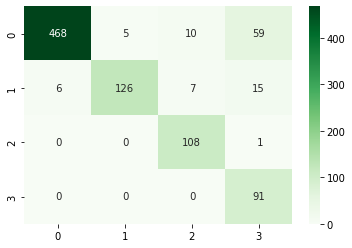

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df_VGG_GOOGLE['classes'],pred_df_VGG_GOOGLE['pred_CLASS'])}")
sns.heatmap(confusion_matrix(pred_df_VGG_GOOGLE['classes'],pred_df_VGG_GOOGLE['pred_CLASS']), annot=True, fmt='2d', cmap='Greens');

## Combinação 2 

### Modelo VGG19 Categoria com Modelo ResNet Classes

### Execução modelo VGG19 Categoria

In [ ]:
pred_VGG19 = VGG19_rede_MB.predict(test_images_VGG19_MB)
pred_VGG19_gmax=np.argmax(pred_VGG19,axis=1)

In [ ]:
labels={}
pred_df_VGG19_MB=df_teste.copy()
for l,v in test_images_VGG19_MB.class_indices.items():
    labels.update({v:l})
pred_df_VGG19_MB['pred']=pred_VGG19_gmax
pred_df_VGG19_MB['pred']=pred_df_VGG19_MB['pred'].apply(lambda x: labels[x])
pred_df_VGG19_MB =  pred_df_VGG19_MB[pred_df_VGG19_MB["pred"] == "M"]

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_VGG19_MB['Type'],pred_df_VGG19_MB['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.00      0.00      0.00        79
           M       0.92      1.00      0.96       896

    accuracy                           0.92       975
   macro avg       0.46      0.50      0.48       975
weighted avg       0.84      0.92      0.88       975



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_df_VGG19_MB["classes"][(pred_df_VGG19_MB['classes'] != 'DC') & (pred_df_VGG19_MB['classes'] != 'LC') & (pred_df_VGG19_MB['classes'] != 'MC') & (pred_df_VGG19_MB['classes'] != 'PC')] = "Erro"

### Configuração da ResNet Classe

In [ ]:
test_generator_ResNet_classe = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [ ]:
test_images_ResNet_classe = test_generator_ResNet_classe.flow_from_dataframe(
    dataframe=pred_df_VGG19_MB,
    x_col='FikePath',
    y_col='classes',
    classes=['DC','LC','MC','PC'],
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 896 validated image filenames belonging to 4 classes.


In [ ]:
resNet_classes = build_model_classe("Resnet")
resNet_classes.load_weights('/content/drive/MyDrive/TCC/weights/ResNet50/ResNet_class.h5')
opt = Adam(learning_rate=0.0001)
resNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
pred_ResNet = resNet_classes.predict(test_images_ResNet_classe)
pred_ResNet_gmax=np.argmax(pred_ResNet,axis=1)

In [ ]:
pred_df_VGG_ResNet =  pred_df_VGG19_MB[pred_df_VGG19_MB['classes'] != "Erro"]
labels={}
for l,v in test_images_ResNet_classe.class_indices.items():
    labels.update({v:l})
pred_df_VGG_ResNet['pred_CLASS']=pred_ResNet_gmax
pred_df_VGG_ResNet['pred_CLASS']=pred_df_VGG_ResNet['pred_CLASS'].apply(lambda x: labels[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(f"Metrics Score: {classification_report(pred_df_VGG_ResNet['classes'],pred_df_VGG_ResNet['pred_CLASS'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.95      0.80      0.87       542
          LC       0.89      0.84      0.87       154
          MC       0.91      1.00      0.95       109
          PC       0.52      1.00      0.68        91

    accuracy                           0.85       896
   macro avg       0.82      0.91      0.84       896
weighted avg       0.89      0.85      0.86       896



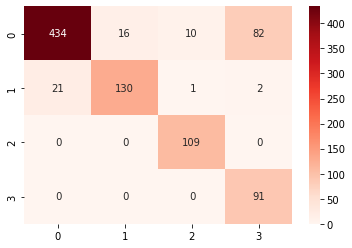

In [ ]:
sns.heatmap(confusion_matrix(pred_df_VGG_ResNet['classes'],pred_df_VGG_ResNet['pred_CLASS']), annot=True, fmt='2d', cmap='Reds');

## Combinação 3 

### Modelo GoogleNet Categoria com Modelo ResNet Classes

### Configuração da GoogleNet Categoria

In [ ]:
test_generator_googleNet_MB = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

In [ ]:
test_images_googleNet_MB  = test_generator_googleNet_MB.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1834 validated image filenames belonging to 2 classes.


In [ ]:
Interception_rede_MB = build_model("GoogleNet")
Interception_rede_MB.load_weights(filepath=r'/content/drive/MyDrive/TCC/weights/Interception/Interception_MB_com_pesos.h5')
opt = Adam(learning_rate=0.0001)
Interception_rede_MB.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
pred_Interception_MB = Interception_rede_MB.predict(test_images_googleNet_MB)
pred_Interception_MB_gmax=np.argmax(pred_Interception_MB,axis=1)

In [ ]:
labels={}
pred_df_Interceptio_MB=df_teste.copy()
for l,v in test_images_googleNet_MB.class_indices.items():
    labels.update({v:l})
pred_df_Interceptio_MB['pred']=pred_Interception_MB_gmax
pred_df_Interceptio_MB['pred']=pred_df_Interceptio_MB['pred'].apply(lambda x: labels[x])
pred_df_Interceptio_MB =  pred_df_Interceptio_MB[pred_df_Interceptio_MB["pred"] == "M"]

In [ ]:
pred_df_Interceptio_MB["classes"][(pred_df_Interceptio_MB['classes'] != 'DC') & (pred_df_Interceptio_MB['classes'] != 'LC') & (pred_df_Interceptio_MB['classes'] != 'MC') & (pred_df_Interceptio_MB['classes'] != 'PC')] = "Erro"

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_Interceptio_MB['Type'],pred_df_Interceptio_MB['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.00      0.00      0.00        49
           M       0.95      1.00      0.97       907

    accuracy                           0.95       956
   macro avg       0.47      0.50      0.49       956
weighted avg       0.90      0.95      0.92       956



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Configuração da ResNet Classe

In [ ]:
test_generator_ResNet_classe = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [ ]:
test_images_ResNet_classe = test_generator_ResNet_classe.flow_from_dataframe(
    dataframe=pred_df_Interceptio_MB,
    x_col='FikePath',
    y_col='classes',
    classes=['DC','LC','MC','PC'],
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 907 validated image filenames belonging to 4 classes.


In [ ]:
resNet_classes = build_model_classe("Resnet")
resNet_classes.load_weights('/content/drive/MyDrive/TCC/weights/ResNet50/ResNet_class.h5')
opt = Adam(learning_rate=0.0001)
resNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
pred_ResNet = resNet_classes.predict(test_images_ResNet_classe)
pred_ResNet_gmax=np.argmax(pred_ResNet,axis=1)

In [ ]:
pred_df_VGG_ResNet =  pred_df_Interceptio_MB[pred_df_Interceptio_MB['classes'] != "Erro"]
labels={}
for l,v in test_images_ResNet_classe.class_indices.items():
    labels.update({v:l})
pred_df_VGG_ResNet['pred_CLASS']=pred_ResNet_gmax
pred_df_VGG_ResNet['pred_CLASS']=pred_df_VGG_ResNet['pred_CLASS'].apply(lambda x: labels[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(f"Metrics Score: {classification_report(pred_df_VGG_ResNet['classes'],pred_df_VGG_ResNet['pred_CLASS'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.95      0.80      0.87       544
          LC       0.89      0.84      0.87       154
          MC       0.90      1.00      0.95       112
          PC       0.54      1.00      0.70        97

    accuracy                           0.85       907
   macro avg       0.82      0.91      0.85       907
weighted avg       0.89      0.85      0.86       907



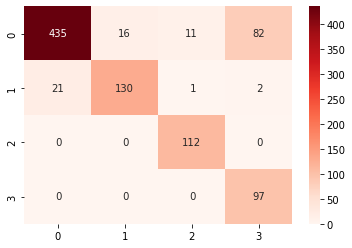

In [ ]:
sns.heatmap(confusion_matrix(pred_df_VGG_ResNet['classes'],pred_df_VGG_ResNet['pred_CLASS']), annot=True, fmt='2d', cmap='Reds');

## Combinação 4

### Modelo GoogleNet Categoria com Modelo GoogleNet Classes

### Configuração da GoogleNet Categoria

In [ ]:
test_generator_googleNet_MB = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

In [ ]:
test_images_googleNet_MB  = test_generator_googleNet_MB.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1834 validated image filenames belonging to 2 classes.


In [ ]:
Interception_rede_MB = build_model("GoogleNet")
Interception_rede_MB.load_weights(filepath=r'/content/drive/MyDrive/TCC/weights/Interception/Interception_MB_com_pesos.h5')
opt = Adam(learning_rate=0.0001)
Interception_rede_MB.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
pred_Interception_MB = Interception_rede_MB.predict(test_images_googleNet_MB)
pred_Interception_MB_gmax=np.argmax(pred_Interception_MB,axis=1)

In [ ]:
labels={}
pred_df_Interceptio_MB=df_teste.copy()
for l,v in test_images_googleNet_MB.class_indices.items():
    labels.update({v:l})
pred_df_Interceptio_MB['pred']=pred_Interception_MB_gmax
pred_df_Interceptio_MB['pred']=pred_df_Interceptio_MB['pred'].apply(lambda x: labels[x])
pred_df_Interceptio_MB =  pred_df_Interceptio_MB[pred_df_Interceptio_MB["pred"] == "M"]

In [ ]:
pred_df_Interceptio_MB["classes"][(pred_df_Interceptio_MB['classes'] != 'DC') & (pred_df_Interceptio_MB['classes'] != 'LC') & (pred_df_Interceptio_MB['classes'] != 'MC') & (pred_df_Interceptio_MB['classes'] != 'PC')] = "Erro"

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_Interceptio_MB['Type'],pred_df_Interceptio_MB['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.00      0.00      0.00        49
           M       0.95      1.00      0.97       907

    accuracy                           0.95       956
   macro avg       0.47      0.50      0.49       956
weighted avg       0.90      0.95      0.92       956



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Configuração da GoogleNet Classe

In [ ]:
test_generator_googleNet_classe = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

In [ ]:
test_images_googleNet_classe = test_generator_googleNet_classe.flow_from_dataframe(
    dataframe=pred_df_Interceptio_MB,
    x_col='FikePath',
    y_col='classes',
    classes=['DC','LC','MC','PC'],
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 907 validated image filenames belonging to 4 classes.


In [ ]:
interception_classes = build_model_classe("GoogleNet")
interception_classes.load_weights('/content/drive/MyDrive/TCC/weights/Interception/Interception_class.h5')
opt = Adam(learning_rate=0.0001)
interception_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred_interception = interception_classes.predict(test_images_googleNet_classe)
pred_interception_gmax=np.argmax(pred_interception,axis=1)

In [ ]:

pred_df_Interceptio_GOOGLE =  pred_df_Interceptio_MB[pred_df_Interceptio_MB['classes'] != "Erro"]
labels={}
for l,v in test_images_googleNet_classe.class_indices.items():
    labels.update({v:l})
pred_df_Interceptio_GOOGLE['pred_CLASS']=pred_interception_gmax
pred_df_Interceptio_GOOGLE['pred_CLASS']=pred_df_Interceptio_GOOGLE['pred_CLASS'].apply(lambda x: labels[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
print(f"Metrics Score: {classification_report(pred_df_Interceptio_GOOGLE['classes'],pred_df_Interceptio_GOOGLE['pred_CLASS'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.99      0.86      0.92       544
          LC       0.96      0.82      0.88       154
          MC       0.87      0.99      0.92       112
          PC       0.56      1.00      0.72        97

    accuracy                           0.89       907
   macro avg       0.85      0.92      0.86       907
weighted avg       0.92      0.89      0.89       907



Accuracy Score: 0.886438809261301


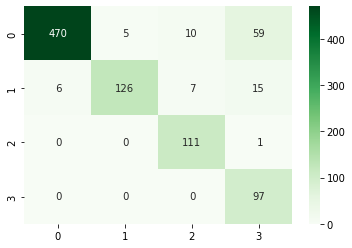

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df_Interceptio_GOOGLE['classes'],pred_df_Interceptio_GOOGLE['pred_CLASS'])}")
sns.heatmap(confusion_matrix(pred_df_Interceptio_GOOGLE['classes'],pred_df_Interceptio_GOOGLE['pred_CLASS']), annot=True, fmt='2d', cmap='Greens');

# Modelo Final

A parti dos resultados apresentados no decorrer do capítulo, é possível perceber que a melhor combinação de modelos é a "Combinação 4", como já tínhamos analisado anteriormente. Mesmo com o desbalanceamento de classes, foi encontrado Resultados suficientemente bons para aplicarmos em nosso modelo final.

Nessa seção apresentaremos o modelo final aplicado.

In [21]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/Imagens')
df_teste_categoria = df_geral[df_geral['DataSet'] == 'Te']

In [22]:
def build_model(Tipo_modelo):
  if Tipo_modelo == "Categoria":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Classe":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  
  return model

In [23]:
test_generator_googleNet_MB = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

In [24]:
test_images_googleNet_MB  = test_generator_googleNet_MB.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1834 validated image filenames belonging to 2 classes.


In [25]:
Interception_rede_MB = build_model("Categoria")
Interception_rede_MB.load_weights(filepath=r'/content/drive/MyDrive/TCC/weights/Interception/Interception_MB_com_pesos.h5')
opt = Adam(learning_rate=0.0001)
Interception_rede_MB.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [26]:
pred_Interception_MB = Interception_rede_MB.predict(test_images_googleNet_MB)
pred_Interception_MB_gmax=np.argmax(pred_Interception_MB,axis=1)

In [27]:
labels={}
pred_df_Interceptio_MB=df_teste.copy()
for l,v in test_images_googleNet_MB.class_indices.items():
    labels.update({v:l})
pred_df_Interceptio_MB['pred']=pred_Interception_MB_gmax
pred_df_Interceptio_MB['pred']=pred_df_Interceptio_MB['pred'].apply(lambda x: labels[x])
pred_df_Interceptio_MB =  pred_df_Interceptio_MB[pred_df_Interceptio_MB["pred"] == "M"]

In [28]:
pred_df_Interceptio_MB["classes"][(pred_df_Interceptio_MB['classes'] != 'DC') & (pred_df_Interceptio_MB['classes'] != 'LC') & (pred_df_Interceptio_MB['classes'] != 'MC') & (pred_df_Interceptio_MB['classes'] != 'PC')] = "Erro"

In [29]:
test_generator_googleNet_classe = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

In [30]:
test_images_googleNet_classe = test_generator_googleNet_classe.flow_from_dataframe(
    dataframe=pred_df_Interceptio_MB,
    x_col='FikePath',
    y_col='classes',
    classes=['DC','LC','MC','PC'],
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 907 validated image filenames belonging to 4 classes.


In [31]:
interception_classes = build_model("Classe")
interception_classes.load_weights('/content/drive/MyDrive/TCC/weights/Interception/Interception_class.h5')
opt = Adam(learning_rate=0.0001)
interception_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [32]:
pred_interception = interception_classes.predict(test_images_googleNet_classe)
pred_interception_gmax=np.argmax(pred_interception,axis=1)

In [33]:

pred_df_Interceptio_GOOGLE =  pred_df_Interceptio_MB[pred_df_Interceptio_MB['classes'] != "Erro"]
labels={}
for l,v in test_images_googleNet_classe.class_indices.items():
    labels.update({v:l})
pred_df_Interceptio_GOOGLE['pred_CLASS']=pred_interception_gmax
pred_df_Interceptio_GOOGLE['pred_CLASS']=pred_df_Interceptio_GOOGLE['pred_CLASS'].apply(lambda x: labels[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


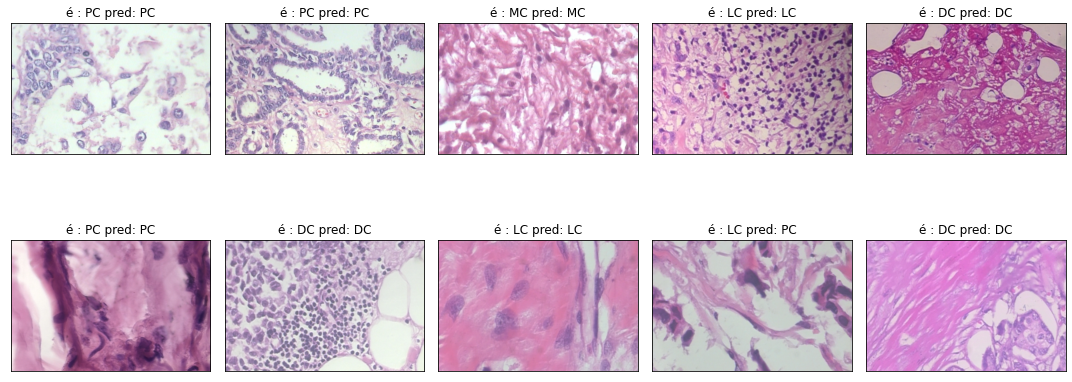

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,pred_df_Interceptio_GOOGLE.shape[0]-1)
    ax.imshow(plt.imread(list(pred_df_Interceptio_GOOGLE.FikePath)[ponteiro]))
    ax.set_title(f'é : {list(pred_df_Interceptio_GOOGLE.classes)[ponteiro]} pred: {list(pred_df_Interceptio_GOOGLE.pred_CLASS)[ponteiro]}')
plt.tight_layout()
plt.show()